## To do list:

* Figure out how to run standardized model on original dataset
* Shale Hills pits are converted to nan, which seems to be due to the fact that there is no soil moisture or Bulk EC data. We may need to run another model without soil moisture and bulk EC if we want to include Shale Hills.
* Should we include site and pit in the PCA?
* Add a column for season
* Add a date column?


In [1]:
#This cell is an attempt at only using 1 for loop to loop through each pit, but there are so many differences between each pit for loop that I'm not sure it can be done
#Don't run, skip to next cell
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive list
# of all potential features across all pits
features = ['CO2', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential', 'Depth']
m = len(features)

# Load in and merge all files
# NOTE: Only doing Calhoun R1C1 for now, but you get the idea
i = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        
        if pit not in ['R1C2', 'SFPit1', 'SPMS']:
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))

            # t is the number of time steps
            t = df.shape[0]

            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            #for a in range(len(cur_data)):
                #print (unique_depths)
                #for i, depth in enumerate(unique_depths):
                    #if depth!='60(2)':
                        #cur_data[:,8]= depth
            for i, depth in enumerate(unique_depths):
                #print (i)
                #print (depth)
                #if depth!='60(2)':
                    #cur_data[:,8]=depth
                #np.append(cur_data,depth)
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]

                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]

                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue
                        

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan   
                    
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
            data[pit] = cur_data.copy()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive list
# of all potential features across all pits
features = ['CO2', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential', 'Pit', 'Depth', 'Site']
m = len(features)

# Load in and merge all files
# NOTE: Only doing Calhoun R1C1 for now, but you get the idea
i = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        
        if pit == 'R1C1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
           
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan     
                    cur_data[:,8]=1
                    cur_data[:,10]=1
                    cur_data[len(cur_data)//2:, 9]=50
                    cur_data[0:len(cur_data)//2, 9]=150
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
            data[pit] = cur_data.copy()
            
        if pit == 'R1H1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=2
                    cur_data[:,10]=1
                    cur_data[len(cur_data)//2:, 9]=50
                    cur_data[0:len(cur_data)//2, 9]=150
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
       
    
        if pit == 'R1P1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=3
                    cur_data[:,10]=1
                    cur_data[len(cur_data)//2:, 9]=50
                    cur_data[0:len(cur_data)//2, 9]=150
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'LRMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=4
                    cur_data[:,10]=2
                    cur_data[len(cur_data)//2:, 9]=unique_depths[0]
                    cur_data[0:len(cur_data)//2, 9]=unique_depths[1]
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'TMMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=5
                    cur_data[len(cur_data):, 9]=unique_depths[0]
                    cur_data[:,10]=2
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'NPMS':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=6
                    cur_data[:,10]=2
                    cur_data[len(cur_data):, 9]=unique_depths[0]
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'SPVF':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=7
                    cur_data[:,10]=2
                    cur_data[len(cur_data)//2:, 9]=unique_depths[0]
                    cur_data[0:len(cur_data)//2, 9]=unique_depths[1]
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,7]=np.nan
                    cur_data[:,6]=np.nan
                    cur_data[:,3]=np.nan
                    cur_data[:,2]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
          
      
        if pit == 'BGZOB1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue
                        if np.all(df[col])==0:
                            df[col]=np.nan
                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=8
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=10
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=30
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'BGZOB2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=9
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=10
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=30
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=60
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=100
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
       
        if pit == 'BGZOB3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=10
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=10
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=30
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=60
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=100
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'BGZOB4':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=11
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=10
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=30
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=60
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=80
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'Green1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=12
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=2
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=10
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=30
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'Green2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=13
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=2
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=10
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=30
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'Green3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=14
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=2
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=10
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=30
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC1':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=15
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=2
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=10
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=30
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC2':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=16
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//2, 9]=2
                    cur_data[len(cur_data)//2:len(cur_data), 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'MC3':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=17
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=2
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=10
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=30
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC4':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=18
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=2
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=10
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=30
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
        if pit == 'MC5':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=19
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=2
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=10
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=30
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()
            
        if pit == 'MC6':
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))
            
            # t is the number of time steps
            t = df.shape[0]
            
            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)
            
            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]
                        
                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]
                        
                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[:,8]=20
                    cur_data[:,10]=3
                    cur_data[0:len(cur_data)//4, 9]=2
                    cur_data[len(cur_data)//4:2*len(cur_data)//4, 9]=10
                    cur_data[2*len(cur_data)//4:3*len(cur_data)//4, 9]=30
                    cur_data[3*len(cur_data)//4:4*len(cur_data)//4, 9]=60
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
                    
            data[pit] = cur_data.copy()

In [2]:
merged=np.vstack(( data['R1C1'], data['R1H1'], data['R1P1'],  data['TMMS'], data['LRMS'], data['NPMS'], data['SPVF'], data['BGZOB1'], data['BGZOB2'], data['BGZOB3'], data['BGZOB4'], data['Green1'], data['Green2'], data['Green3'], data['MC1'], data['MC2'], data['MC3'], data['MC4'], data['MC5'], data['MC6']))
#
df=pd.DataFrame(data=merged, columns=['CO2', 'Precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential', 'Pit','Depth', 'Site'])

In [3]:
df.dropna(subset=['CO2'], inplace=True)
df

,CO2,Precip,SoilMoisture,BulkEC,Temp,O2,WaterPotential,ReductionPotential,Pit,Depth,Site
0,13180.00000,NaN,0.358,0.044,16.65000,19.409336,NaN,0.000,1.0,150.0,1.0
1,13570.00000,0.0,0.358,0.044,16.70500,19.413019,NaN,0.000,1.0,150.0,1.0
2,13830.00000,0.0,0.358,0.044,16.77000,19.417373,NaN,0.000,1.0,150.0,1.0
3,14100.00000,0.0,0.358,0.044,16.83500,19.421726,NaN,0.000,1.0,150.0,1.0
4,14315.00000,0.0,0.358,0.044,16.89000,19.425410,NaN,0.000,1.0,150.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2691424,908.66450,NaN,NaN,NaN,1.95875,12.620250,NaN,412.000,20.0,60.0,3.0
2691425,899.26600,NaN,NaN,NaN,1.96000,12.633500,NaN,412.125,20.0,60.0,3.0
2691426,906.60550,NaN,NaN,NaN,1.95975,12.656000,NaN,412.100,20.0,60.0,3.0
2691427,907.19025,NaN,NaN,NaN,1.95500,12.660750,NaN,412.725,20.0,60.0,3.0


In [522]:
np.mean(df.SoilMoisture[df.Site==2])

nan

In [500]:
final_array=df.to_numpy()
output=final_array.copy()
outfile = '../../merged_processed_data/MergeProcessedData.csv'
#output.to_csv(outfile, na_rep=-99999, index_label='record', float_format='%.3f')
np.savetxt(outfile, output, fmt='%.4f', delimiter=",")


In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [5]:
df=df.drop(columns='WaterPotential')
df=df.drop(columns='ReductionPotential')
df=df.dropna()
df

,CO2,Precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site
1,13570.00000,0.00,0.3580,0.044,16.70500,19.413019,1.0,150.0,1.0
2,13830.00000,0.00,0.3580,0.044,16.77000,19.417373,1.0,150.0,1.0
3,14100.00000,0.00,0.3580,0.044,16.83500,19.421726,1.0,150.0,1.0
4,14315.00000,0.00,0.3580,0.044,16.89000,19.425410,1.0,150.0,1.0
5,14515.00000,0.00,0.3580,0.044,16.94000,19.428758,1.0,150.0,1.0
...,...,...,...,...,...,...,...,...,...
2687378,2293.51950,7.05,0.1780,0.000,15.29050,12.237500,20.0,60.0,3.0
2687379,2250.84025,7.05,0.1780,0.000,15.16400,12.252000,20.0,60.0,3.0
2687380,2227.83200,7.05,0.1775,0.000,15.07350,12.249500,20.0,60.0,3.0
2687381,2204.82800,7.05,0.1770,0.000,15.01625,12.255750,20.0,60.0,3.0


In [6]:
df['new_index']=list(range(0, 758303))
df_reindex=df.set_index('new_index')
df=df.drop(columns='new_index')
df_reindex=df_reindex.drop(columns='Site')

df_st =  StandardScaler().fit_transform(df_reindex) 
df_st1=pd.DataFrame(data=df_st)
#df_med=df_st1.fillna(df_st1.median())
df[df.Site==2]

,CO2,Precip,SoilMoisture,BulkEC,Temp,O2,Pit,Depth,Site


In [22]:
#df_st1=pd.DataFrame(data=df_st)
#df_med = df_st1.fillna(df_st1.median())
#pca = PCA(.95)
#pca.fit(X_train)
#X_train = pca.transform(X_train)
#X_test = pca.transform(X_test)

In [7]:
pca = PCA(.95)
pca.fit(df_st)
df_st_transform = pca.transform(df_st)
df_st_transform
df_st=df_st[df_st_transform[:,0]<=12]
pca = PCA(.95)
pca.fit(df_st)
df_st_transform = pca.transform(df_st)
len(df_st[:,0])

758297

In [8]:
#pca_scores = PCA().fit_transform(df_st)

#df_st
#df_pca=pd.DataFrame(data=pca_scores)
#df_pca.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Pit', 'Depth']
pca.explained_variance_ratio_


array([0.31204842, 0.2264869 , 0.12602809, 0.11191438, 0.07440414,
       0.06845278, 0.05521436])

In [9]:
pca_out=pca
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_reindex.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
variable,,,,,,,
CO2,-0.236572,0.508123,0.103787,-0.317461,-0.077069,0.638673,-0.398753
Precip,-0.000266,0.194337,0.831579,0.516439,0.009379,0.005008,0.056852
SoilMoisture,0.189416,0.546780,-0.321007,0.369955,0.043717,-0.338933,-0.300484
BulkEC,0.357948,0.334100,0.011436,-0.202692,0.760646,0.065812,0.318332
Temp,-0.358316,0.229638,0.302747,-0.571522,-0.042083,-0.588973,0.122143
O2,-0.456782,-0.345367,0.017117,0.120791,0.529953,0.185842,-0.009836
Pit,0.531843,-0.080231,0.165620,-0.239894,-0.293786,0.250623,0.332229
Depth,-0.400164,0.339122,-0.274135,0.236181,-0.211063,0.169196,0.721628


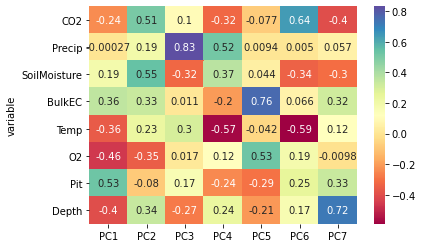

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

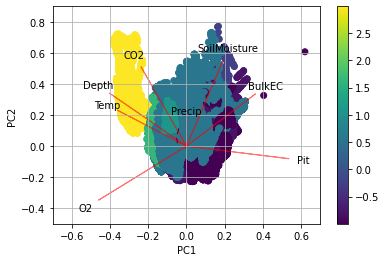

In [11]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = df_st[:,7])
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, df.columns.values[i], color = 'k', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-.7,.7)
    plt.ylim(-.5,.9)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.colorbar()

#Call the function. Use only the 2 PCs.
myplot(df_st_transform[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [30]:
import bioinfokit
from bioinfokit.visuz import cluster
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

In [31]:
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

In [ ]:
#Run this for machine learning model with standardization

from sklearn.model_selection import train_test_split

df_st1.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Pit', 'Depth', 'Site']
X=df_st1[['Precip', 'Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Pit', 'Depth']]  # Features\n",
y=df_st1['CO2']  # Labels\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [12]:
#Run this for machine learning model without standardization

from sklearn.model_selection import train_test_split

df.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Pit', 'Depth', 'Site']
X=df[['Precip', 'Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Pit', 'Depth', 'Site']]  # Features\n",
y=df['CO2']  # Labels\n",
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
neigh.score(X_test,y_test)

0.971057194688421

In [14]:
len(X_train)


606642

In [15]:
#X_original=df.iloc[y_train]
prediction=neigh.predict(X_test)
df_pred=pd.DataFrame(data=prediction)
#prediction_original_dataset=neigh.predict(X_original)


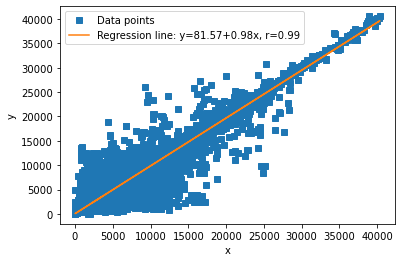

In [17]:
import scipy.stats
x=y_test
y=prediction
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [18]:
result = scipy.stats.linregress(y_test, prediction)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(y_test, prediction))
print(metrics.max_error(y_test, prediction))
print(metrics.mean_absolute_error(y_test, prediction))
print(metrics.mean_squared_error(y_test, prediction, squared=False))




0.9854652153505195
0.0
0.9798332346137035
0.00043372276215528045
0.971057194688421
16777.5
228.30944931562004
671.4986533201957


In [19]:
r, p = scipy.stats.pearsonr(y_test, prediction)
print (r)
print (p)

0.9854652153505192
0.0


In [20]:
result = scipy.stats.spearmanr(y_test, prediction)
print (result.correlation)
print (result.pvalue)

0.9750862939654055
0.0


In [21]:

result = scipy.stats.kendalltau(y_test, prediction)
print (result.correlation)
print (result.pvalue)

0.9137826224527774
0.0


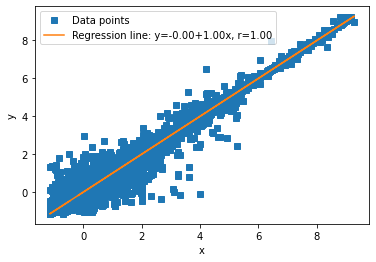

In [117]:
#Standardized model performs slightly better, but I can't figure out how to test the standardized model on different depths or pits. 
#I also can't figure out how to inverse transform the standardized values to get predictions for the the original dataframe, so I am just using the unstandardized model

x=y_test
y=prediction
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [22]:
y_hats=prediction
df_out = X_test.reset_index()
df_out["Actual"] = y_test.reset_index()['CO2']
df_out["Prediction"] = y_hats#.reset_index()[0]
y_test['preds'] = y_hats
df_out
#df_out = pd.merge(df,y_test[['preds']],how = 'left',left_index = True, right_index = True)

,index,Precip,Soil Moisture,Bulk EC,Temp,O2,Pit,Depth,Site,Actual,Prediction
0,941101,0.00,0.060000,0.000000,14.654000,19.39975,14.0,60.0,3.0,3692.73050,3684.575875
1,1215751,0.00,0.238000,0.020000,7.439250,13.60400,15.0,60.0,3.0,2178.05075,2122.738375
2,2375213,0.38,0.221000,0.130000,1.667250,12.51750,19.0,60.0,3.0,5789.26200,5785.211750
3,955936,0.60,0.120000,0.010000,1.663000,19.97850,14.0,60.0,3.0,2617.97875,2619.160625
4,959064,15.54,0.030000,0.002500,14.504750,19.59050,14.0,60.0,3.0,5226.94900,5194.862250
...,...,...,...,...,...,...,...,...,...,...,...
151656,596127,0.00,0.089000,0.010000,11.056750,18.86200,10.0,100.0,3.0,4756.85050,4832.871500
151657,697403,1.50,0.126000,0.012500,13.837500,17.66000,11.0,80.0,3.0,2490.14400,2469.533250
151658,2082452,0.00,0.244833,0.050000,8.511350,13.05320,18.0,60.0,3.0,3289.79875,3620.428625
151659,1941148,25.23,0.221000,0.128333,10.657675,11.15760,18.0,10.0,3.0,2747.79425,2723.394250


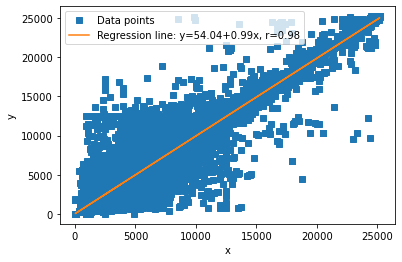

In [23]:
#For some reason the Shale Hills data has been dropped
#All pits show high level of prediction accuracy (pit 20 is probably lowest accuracy)

df_out=df_out.astype('float32')
x=df_out.Prediction[df_out.Site==3]
y=df_out.Actual[df_out.Site==3]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [24]:
result = scipy.stats.linregress(x, y)
print(result.rvalue)
print(result.pvalue)
print (result.stderr)
print (r2_score(x, y))
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))


0.9818268745056986
0.0
0.0005002263111505214
0.9632821973910396
16366.94
224.65718
657.5098


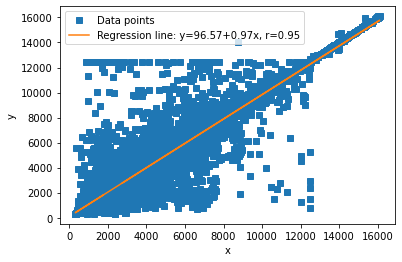

In [30]:
x=df_out.Prediction[df_out.Depth==2]
y=df_out.Actual[df_out.Depth==2]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

In [31]:
import scipy.stats
result = scipy.stats.linregress(x, y)
print(result.rvalue)
print(result.pvalue)
print (result.slope)
print (result.stderr)
from sklearn.metrics import r2_score
print (r2_score(x, y))
print(metrics.max_error(x, y))
print(metrics.mean_absolute_error(x, y))
print(metrics.mean_squared_error(x, y, squared=False))


0.9468114299326165
0.0
0.9740731890348098
0.0018740755955364203
0.8896377205078887
11663.627
278.59265
761.34607


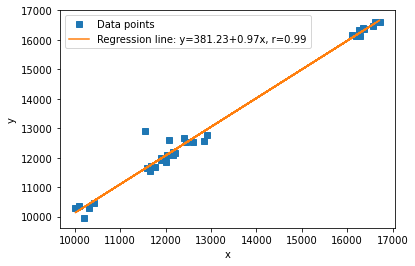

In [32]:
x=df_out.Prediction[df_out.Temp>=31.5]
y=df_out.Actual[df_out.Temp>=31.5]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()

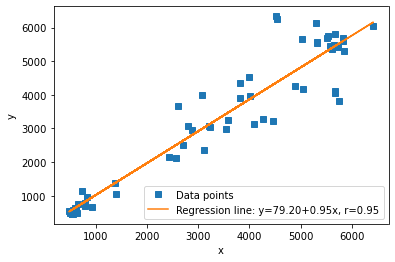

In [33]:
x=df_out.Prediction[df_out.Temp<=-3]
y=df_out.Actual[df_out.Temp<=-3]
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(facecolor='white')
plt.show()